In [8]:

import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from scipy import stats
from importlib import reload
sys.path.insert(1, './functions/')
import os
from utility import create_folder


In [9]:
import fun_decoder; reload(fun_decoder)
from fun_decoder import shuffle_decoder_models
from fun_models_class import find_effective_nef

def find_effective_nef_models(result_models,tol_ratio = 0.01):
    model_names = result_models.keys()

    for model_name in model_names:
        W = result_models[model_name]['W']
        nef = find_effective_nef(W,tol_ratio=tol_ratio )
        result_models[model_name]['scores']['nef'] =nef
    return result_models


In [10]:
scale = 5
cm2inch = 0.39
ssmall_SIZE = 3*scale
SMALL_SIZE = 4*scale
MEDIUM_SIZE = 6*scale
BIGGER_SIZE = 8*scale
LINE_WIDTH = 2*2
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('lines', linewidth=LINE_WIDTH)


In [11]:
def extract_score_models_cats(score_models_cats, model_names=None):
    if model_names is None:
        model_names = list(score_models_cats.keys())
    cats = list(score_models_cats[model_names[0]].keys())

    score_cats_models = dict()
    for cat in cats:
        score_cats_models[cat]=dict()
        for model_name in model_names:
            score_cats_models[cat][model_name] = score_models_cats[model_name][cat]
    # plot
    return score_cats_models
def plot_scores_ps(score_models_cats,p_models_cats,model_names,
                    ymax=0.8,savepath = None,suffix = [], figsize = None,
                    markersize = 10, model_name_labels = None,
                    cats=['LR','FB'], title = None):

    score_cats_models = extract_score_models_cats(score_models_cats, model_names=model_names)
    p_cats_models = extract_score_models_cats(p_models_cats, model_names = model_names)

    fig, ax = plt.subplots(figsize = figsize)
    ax1 = ax.twinx()
    score0 = list(score_cats_models[cats[0]].values())
    p0 = list(p_cats_models[cats[0]].values())
  
    ax.plot(score0,'o-',color ='b',markersize = markersize, label ='correct rate ('+cats[0]+')')
    ax1.plot(p0, '.-',  color ='lightblue',
        label='p-value (LR)')
    
    
    ax1.hlines(y = 0.05, xmin = 0-0.1, xmax = len(model_names)-1+0.1,
            linestyles ='--', linewidth = 1, color ='red',
            label ='p = 0.05')

    ax.plot(score_cats_models[cats[1]].values(),'o-',color ='orange', markersize = markersize,label ='correct rate ('+cats[1]+')')
    ax1.plot(p_cats_models[cats[1]].values(), '.-', color ='bisque',
        label='p-value (FB)')

    idx = np.where(np.array(p0)<=0.05)[0]

    if len(idx)>0:
        for i in idx:
            ax.plot(i,score0[int(i)], 'bo', markersize = markersize,
                    markeredgewidth = 2,
                    markeredgecolor = 'r')
        ax.plot(i,score0[int(i)], 'o', markersize = markersize,
                    markeredgewidth = 2,
                    markeredgecolor = 'r',
                    markerfacecolor ='none',
                    label ='Correct rate (p<0.05)')
    ax.set_ylim([0,ymax])
    ax1.set_ylim([0,3])
    ax1.set_yticks(np.arange(0,1.1,0.25))
    ax.legend(loc ='upper left',framealpha =0.5)
    ax1.legend(loc = 'center right',framealpha = 0.5)
    ax.set_xticks(np.arange(len(model_names)))
    if model_name_labels is None:
        model_name_labels = model_names
    ax.set_xticklabels(model_name_labels, rotation = 45)
    ax.set_ylabel('Correct rate')
    ax1.set_ylabel('p-value')
    if title is None:
        title ='Decoder performance'
    ax.set_title(title)
    if savepath is not None:
        figname = 'score_p_'+suffix+'.pdf'
        figfile = os.path.join(savepath, figname)
        fig.savefig(figfile, bbox_inches='tight')
    plt.show()



def get_model_name_labels(model_names):
    xticks = [None]*len(model_names)
    for i in range(len(model_names)):
        if model_names[i] == 'pca':
            xticks[i] = 'PCA'
        elif model_names[i] =='mlpca':
            xticks[i] = 'Probabilistic PCA'
        elif model_names[i] =='fa':
            xticks[i] = 'Factor analysis'
        elif model_names[i] =='bpca_common':
            xticks[i] = 'Bayesian PCA'
        elif model_names[i] =='bpca_individual':
            xticks[i] = 'Bayesian PCA (individual)'
        elif model_names[i] =='mbpca_common':
            xticks[i] = 'dual ARD (common)'
        elif model_names[i] =='mbpca_individual':
            xticks[i] = 'dual ARD (individual)'
        elif model_names[i] =='population':
            xticks[i] ='Full population neurons'
    return xticks

def plot_nef_models(nef_models, model_name_labels = None,
                    markersize = 10,savepath = None,suffix=[],figsize = None):
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(nef_models.values(), 'go-', label='nef', markersize = markersize)
    ax.set_xticks(np.arange(len(nef_models)))
    if model_name_labels is None:
        model_name_labels = nef_models.keys()
    ax.set_xticklabels(model_name_labels, rotation = 45)
    plt.legend()
    ax.set_title('Number of dimensions used for decording')
    ax.set_ylabel('Number of dimensions')
    ax.set_ylim([-25,420])
    if savepath is not None:
        figname ='nef_models_'+suffix+'.pdf'
        figfile = os.path.join(savepath,figname)
        plt.savefig(figfile, bbox_inches='tight')
    plt.show()

In [12]:

"""
Load data
"""
depth = 0


from scipy.io import loadmat
data = loadmat('./data/piezo_data1.mat')
spk_on = data['all_spk_scan']
spk_off = data['all_spk_scan_down']
speed = data['all_speed_scan']
move = data['all_move_scan']
trace = data['All_trace'][0,0]['matrix']


# filename ='./results/piezo_models_results.pickle'
filename ='./results/piezo_models_results_1.pickle'
with open(filename,'rb') as f:
    result_models = pickle.load(f)
result_models = find_effective_nef_models(result_models,tol_ratio=0.01)


In [13]:

"""
1. Bayesian decoder
"""
cats = ['LR','FB']
tw = 8
history = 1
results_d = dict()
# for d in ['different', 'same']:
for d in ['same']:
    if d =='different':
        model_names = ['pca','mlpca','fa','bpca_common','bpca_individual',
               'mbpca_common','mbpca_individual','population']
    elif d =='same':
        model_names = ['pca','mlpca','fa','bpca_common','bpca_individual',
                    'mbpca_common','mbpca_individual']
    results_d[d] =shuffle_decoder_models(result_models,spk = spk_on, speed = speed,trace = trace, tw = tw, history = history,
                                    cats = cats,N_shuffle= 1000,model_names=model_names,
                                    d = d)

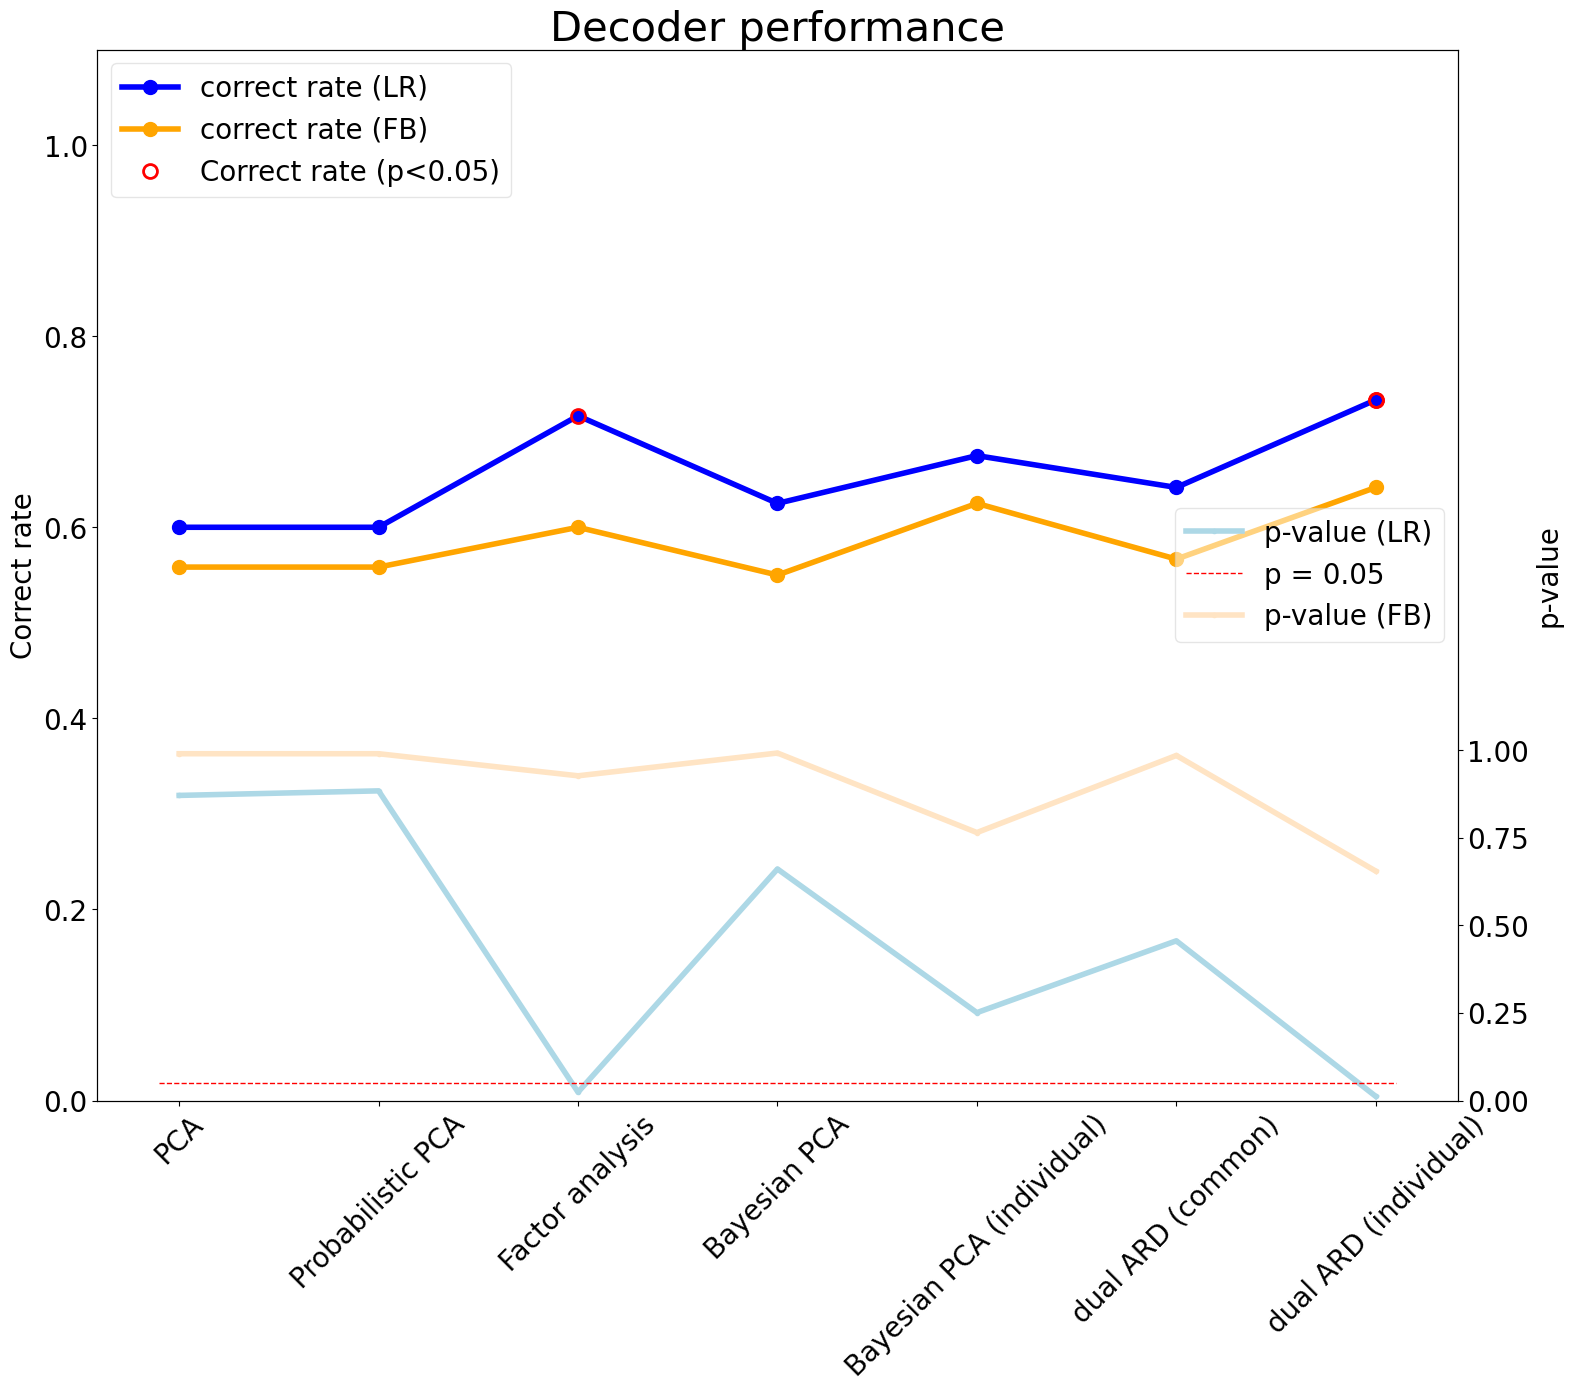

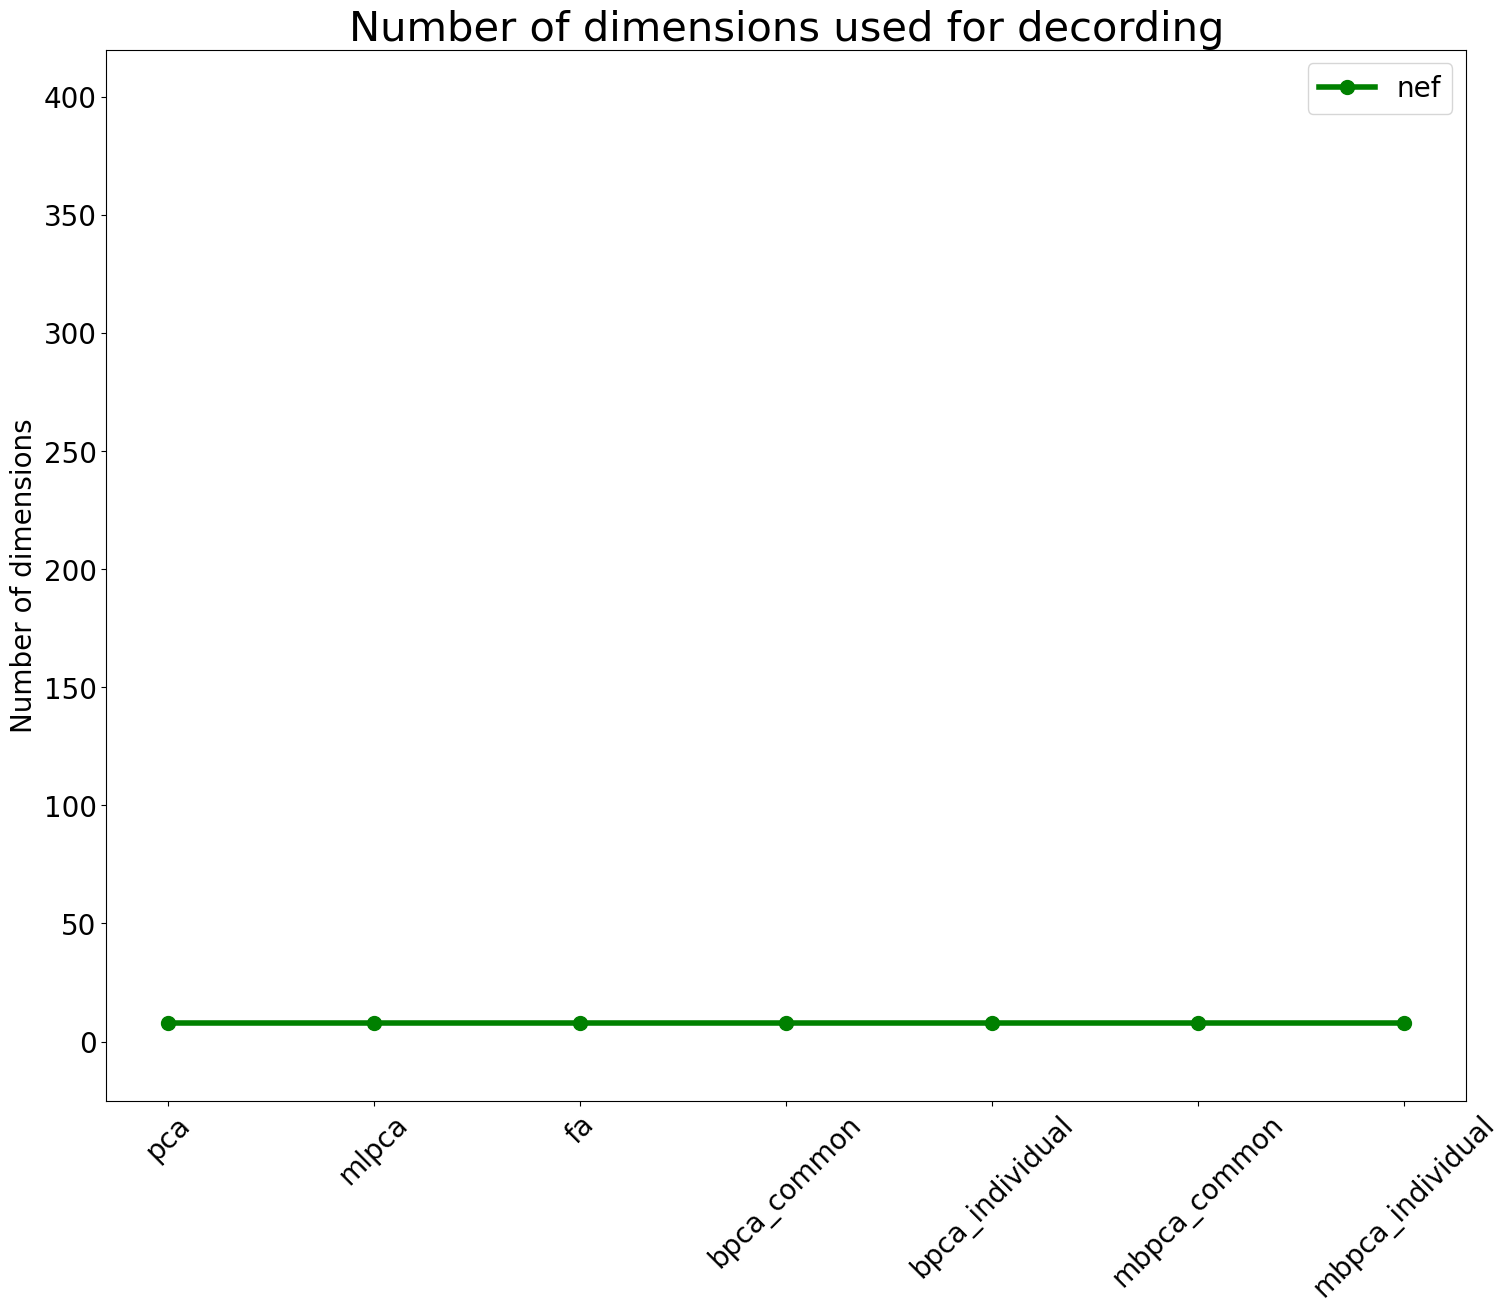

In [14]:


"""
1. plot score_p for LR and RL for all models
"""
savepath ='./figs/decoder/'
create_folder(savepath)
figsize_cm = (9, 7)
figsize = (figsize_cm[0]*scale*cm2inch,figsize_cm[1]*scale*cm2inch)


# for d in ['different', 'same']:
for d in ['same']:
    result = results_d[d]
    score_models_cats = result['score_models_cats']
    p_models_cats = result['p_models_cats']
    nef_models = result['nef_models']
    model_names = list(score_models_cats.keys())
    model_name_labels = get_model_name_labels(model_names)
    if d =='different':
        
        title = 'Decoder performance (maximum effective dimensions)'
    elif d =='same':
        title = 'Decoder performance'


    

    plot_scores_ps(score_models_cats,p_models_cats,model_names=model_names,ymax=1.1,
                        figsize =figsize, markersize = 10,
                        savepath = savepath,suffix = str(d),
                        model_name_labels = model_name_labels,
                        cats =cats, title = title)

    plot_nef_models(nef_models,savepath = savepath,suffix = str(d), figsize = figsize)




In [15]:
def plot_y_predict(y_prob, y, cat='LR',savepath = None, figsize = None):
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(y_prob[:,1],'k', label ='P(y = 1)');
    ax.plot(y,'r.', label ='True')
    plt.legend(loc = 'upper right')
    ax.set_xlabel('Trials')
    ax.set_ylabel('Probability')
    ax.set_title(cat)
    if savepath is not None:
        figname='predict_prob_'+cat+'.pdf'
        figfile = os.path.join(savepath, figname)
        plt.savefig(figfile)
    plt.show()
def plot_shuffle_test(score_shuffle,score_fit,p,cat='LR', savepath = None, figsize = None):
    fig, ax = plt.subplots(figsize = figsize)
    n,_,_ = ax.hist(score_shuffle,color = 'royalblue',bins = 10,alpha = 0.8)
    ax.set_ylim([0,n.max()+10])
    ax.vlines(x = score_fit, ymin = 0, ymax = np.max(n)+10, color ='red', linestyle='--')
    ax.set_title('Accuracy rate:'+str(np.round(score_fit,2))+', p='+str(np.round(p,2))+' ('+cat+')')
    ax.set_xlim([0.5,0.8])
    ax.set_ylabel('Counts')
    ax.set_xlabel('Accuracy rate')
    
    if savepath is not None:
      
        figname='shuffle_test_'+cat+'.pdf'
        figfile = os.path.join(savepath, figname)
        plt.savefig(figfile)
    plt.show()



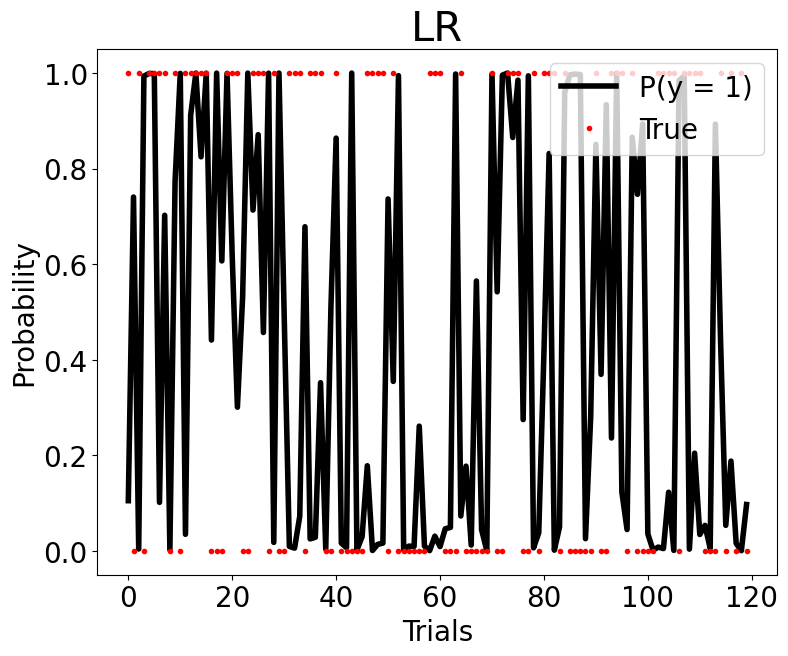

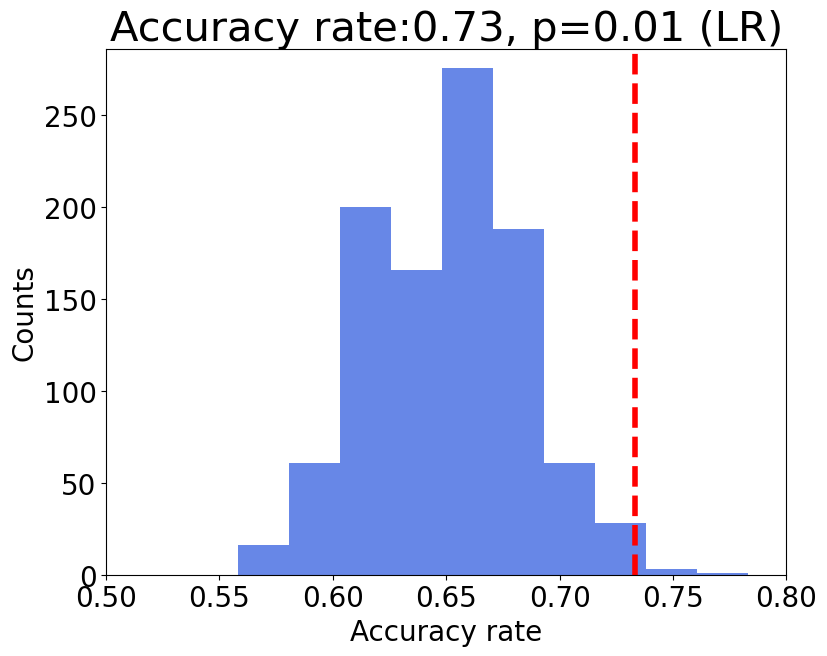

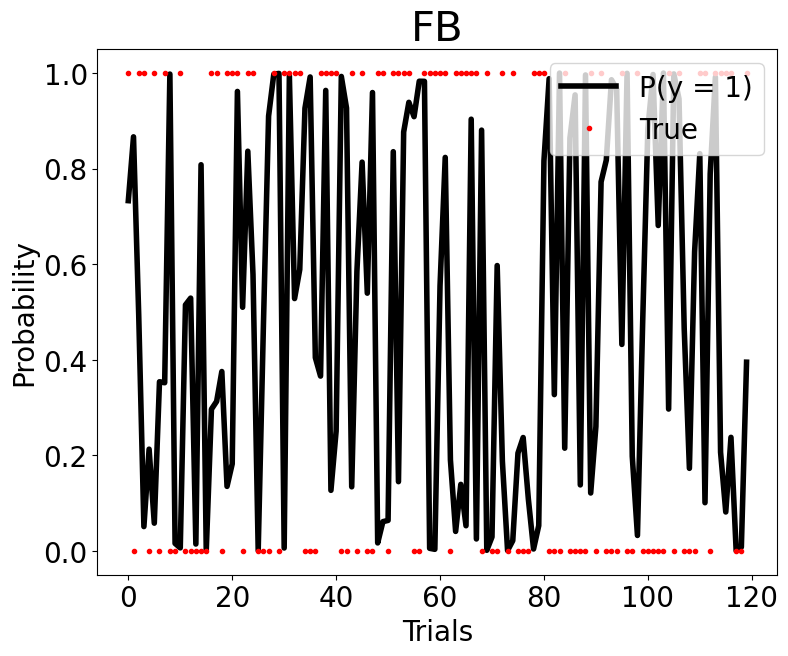

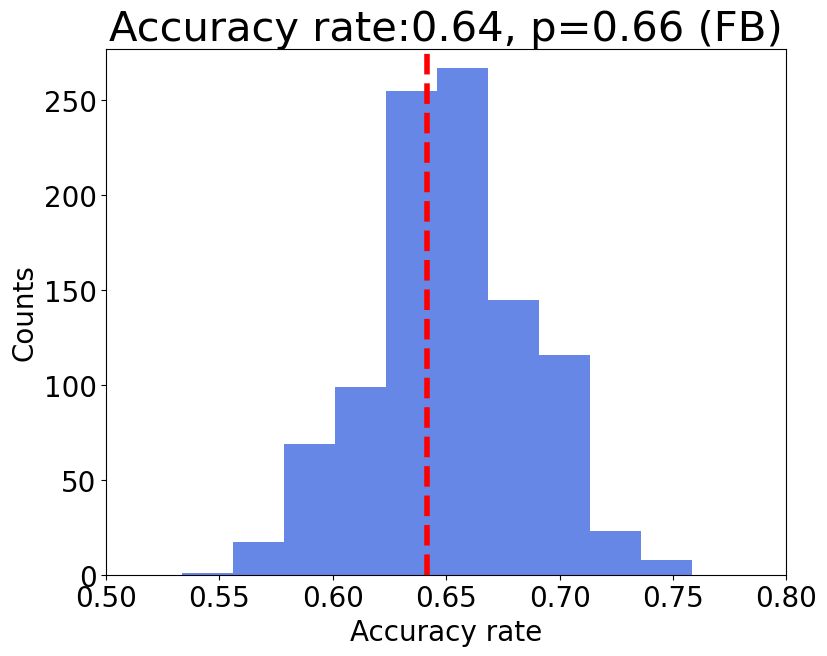

In [16]:
# LINE_WIDTH=2
# plt.rc('lines', linewidth=LINE_WIDTH)

model_name='mbpca_individual'
score_shuffle_models_cats = result['score_shuffle_models_cats']
score_shuffle_cats =score_shuffle_models_cats[model_name]


score_models_cats = result['score_models_cats']
p_models_cats = result['p_models_cats']

predict_prob_models_cats =  result['predict_prob_models_cats']
y_cat_models_cats = result['y_cat_models_cats']
score_models_cats = result['score_models_cats']
"""
3.1 plot y_prob
3.2 plot shuffle test
"""

for cat in cats:
    y_prob = predict_prob_models_cats[model_name][cat]
    y_cat = y_cat_models_cats[model_name][cat]
    score_shuffle = score_shuffle_models_cats[model_name][cat]
    p = p_models_cats[model_name][cat]
    score_fit = score_models_cats[model_name][cat]
    figsize_cm = (4.5, 3.5)
    figsize = (figsize_cm[0]*scale*cm2inch,figsize_cm[1]*scale*cm2inch)

    plot_y_predict(y_prob, y_cat, cat =cat, savepath=savepath,figsize = figsize)
    plot_shuffle_test(score_shuffle,score_fit,p,cat=cat, savepath = savepath, figsize = figsize)


In [17]:
# plot decoder among depths

In [18]:
from fun_decoder import shuffle_decoder
model_name = 'mbpca_individual'

data_type ='data1'
savepath = os.path.join('./results_/results_update_order_xw/',data_type,model_name)
scores_LR_data1 = np.zeros(8)
scores_FB_data1 = np.zeros(8)
ps_LR_data1 = np.zeros(8)
ps_FB_data1 = np.zeros(8)
tw = 6 
history = 1
for depth in range(8):
    filename =  model_name + '_'+data_type+'_depth'+str(depth)+'.pickle'
    savefile = os.path.join(savepath,filename)
    with open(savefile,'rb' ) as f:
        model = pickle.load(f)
    nef =int(model.scores['nef'])
    X = model.X
    X_d = X[0:nef,:]
    # print(nef)
    result_LR = shuffle_decoder(X_d, cat ='LR', spk = spk_on, 
                        tw = tw, history = history)
    scores_LR_data1[depth] = result_LR['score_fit']
    ps_LR_data1[depth] = result_LR['p']


    result_FB = shuffle_decoder(X_d, cat ='FB', spk = spk_on, 
                        tw = tw, history = history)
    scores_FB_data1[depth] = result_FB['score_fit']
    ps_FB_data1[depth] = result_FB['p']
    

In [19]:
# def draw_brace(ax, xspan, yy, text, lw = 2, alpha = 0.5, textpos = 0.02,yscale = 1):
#     """Draws an annotated brace on the axes."""
#     xmin, xmax = xspan
#     xspan = xmax - xmin
#     ax_xmin, ax_xmax = ax.get_xlim()
#     xax_span = ax_xmax - ax_xmin

#     ymin, ymax = ax.get_ylim()
#     yspan = ymax - ymin
#     resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
#     beta = 300./xax_span # the higher this is, the smaller the radius

#     x = np.linspace(xmin, xmax, resolution)
#     x_half = x[:int(resolution/2)+1]
#     y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
#                     + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
#     # y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
#     # ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom', alpha = alpha)
#     y = np.concatenate((y_half_brace[::-1],y_half_brace[1:]))
   
#     ax.text((xmax+xmin)/2., yy-textpos*yspan, text, ha='center', va='bottom', alpha = alpha)

#     y = yy + (.05*y - .01)*yspan # adjust vertical position
#     y = y*yscale
#     ax.autoscale(False)
#     ax.plot(x, y, color='black', lw=lw, alpha = alpha, clip_on=False)


from fun_plots import draw_brace

    

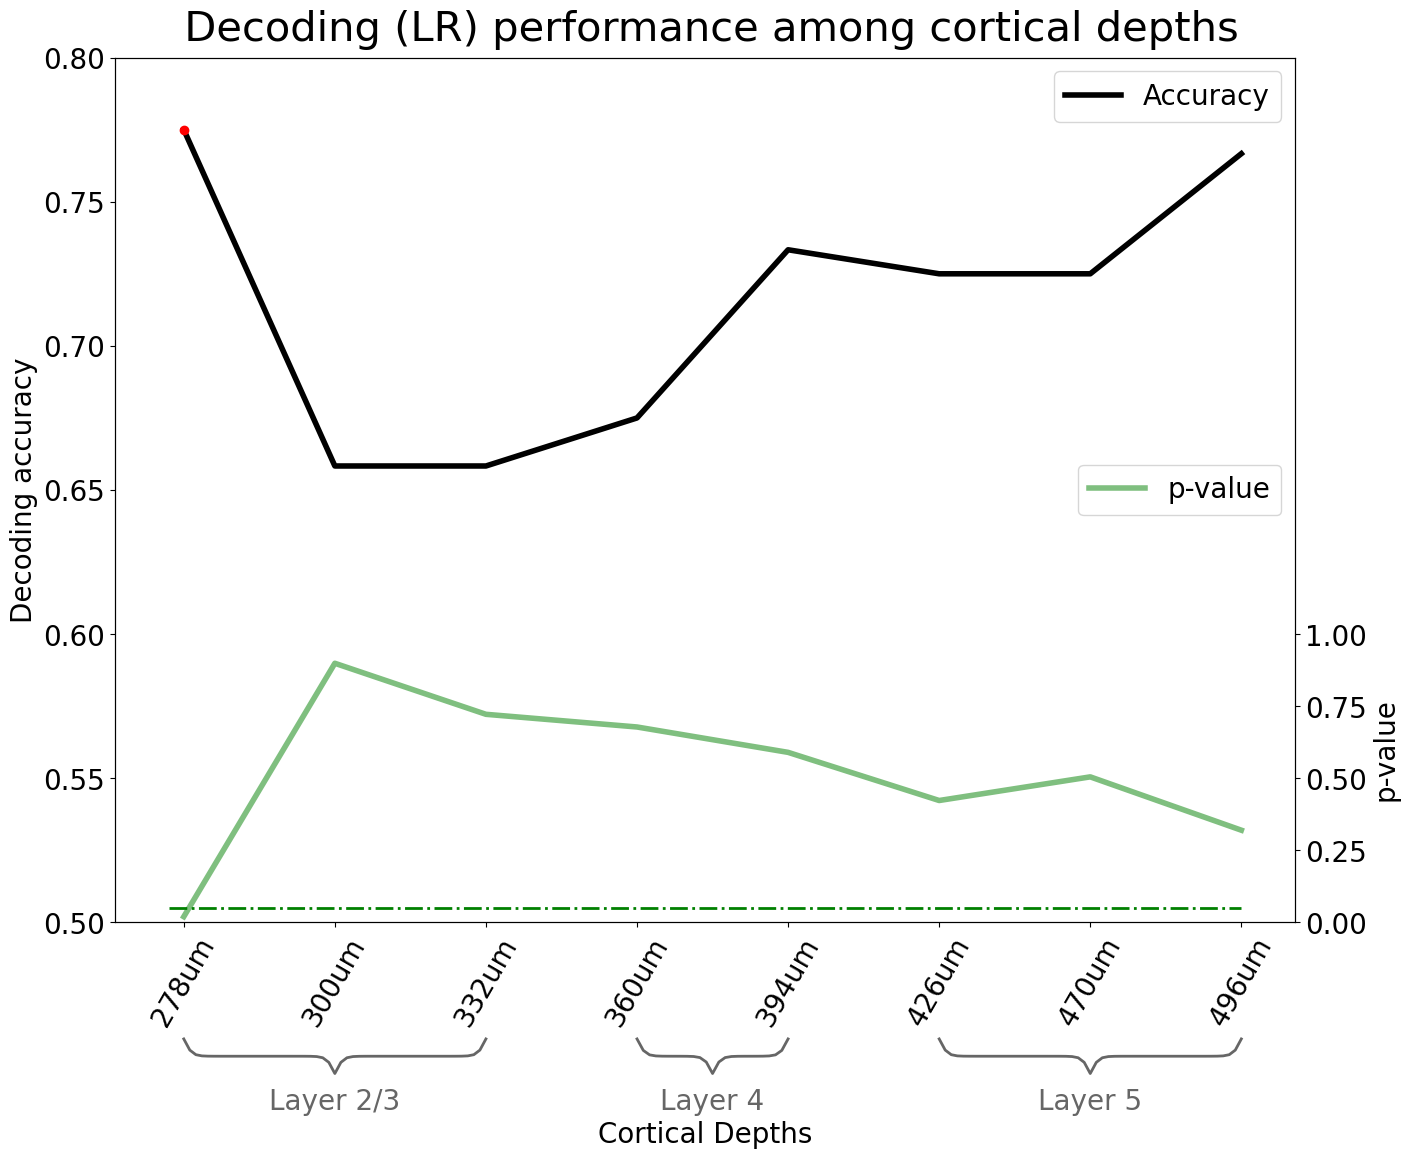

In [20]:
figsize_cm = (9, 7)
figsize_inch = (14.5, 12)
figsize = (figsize_inch[0],figsize_inch[1])


idx = np.where(ps_LR_data1<0.05)[0]
idx1 = np.where(scores_LR_data1>=0)[0]
idx_  = list(set(idx) & set(idx1))

fig, ax = plt.subplots(figsize = figsize)
ax.plot(scores_LR_data1,'k',label='Accuracy')


ax.plot(idx_,scores_LR_data1[idx_],'ro')
ax.set_ylabel('Decoding accuracy')
ax.set_ylim([0.5,0.8])
plt.legend(loc = 'upper right')
ax1 = ax.twinx()
ax1.plot(ps_LR_data1,'green',label ='p-value', alpha = 0.5)


ax1.hlines(y = 0.05, xmin = 0-0.1, xmax = len(ps_LR_data1)-1,linestyles= '-.', color = 'g',linewidth = 2)
# ax1.set_ylim([0,2])
ax1.set_ylim([0,3])
ax1.set_yticks(np.arange(0,1.1,0.25))
plt.legend(loc = 'right')
depths = np.array([278,300,332,360,394,426,470,496])
depths_labels = []
for i in range(len(depths)):
    depthi = depths[i]
    depths_labels.append(str(depths[i])+'um')
ax.set_xticks(np.arange(0, len(depths)))
ax.set_xticklabels(depths_labels, rotation = 60)


xticks = ax.get_xticks()
xtick_rel_position = np.linspace(0.13, 0.81, len(xticks)) # <- these are just guessed

alpha = 0.6
brace_y = -0.7
textpos = -0.01
yscale = 0.8
draw_brace(ax1, (0,2), brace_y, 'Layer 2/3', alpha = alpha, textpos = textpos,yscale = yscale)
draw_brace(ax1, (3,4), brace_y, 'Layer 4',alpha = alpha, textpos = textpos,yscale = yscale)
draw_brace(ax1, (5,7), brace_y, 'Layer 5',alpha = alpha, textpos = textpos,yscale = yscale)
ax.set_xlabel('Cortical Depths',labelpad=65)

ax1.set_ylabel('p-value', y = 0.2)


ax.set_title(' Decoding (LR) performance among cortical depths', y = 1.01)
plt.tight_layout()
plt.savefig('./figs/decoder/decoder_depths.pdf')

plt.show()
